### Experiments with U-Nets on CESM and FOCI slp and sst data to predict current ant future anomaly fields from sparse inputs

Go beyond [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x):
- **Univariate** inputs to predict current and future sst and prec fields, respectively, with lead times: 0, 1, 3 months.
- **Multivariate** inputs (slp, sst, z500, sat, sss, prec) to predict current and future sst and prec fields, respectively.
- **Timelagged** inputs (sst or prec) with lag 0..6 months to predict current and future sst and prec fields, respectively.

Inspect results from **long runs**, models trained over **100 epochs** with **learning rate 0.00005**.
Have loss on training / validation / test data. Use minimum validation loss for early stopping training process.
Evaluate model performance on test data.

In [1]:
import os
from os.path import exists
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

### Reload loss

In [3]:
## Define parameters:

# Number of epochs:
epochs = 100

# Model configuration:
model_config = 'predict_unet_4conv'

# Input type:
input_types = ['univariate'] #['univariate', 'multivariate', 'timelagged']

# Target features:
target_features_short = ['sst'] #['sst', 'prec']

# Sources:
sources = ['CESM', 'FOCI']

# Mask types:
mask_types = ['fixed']#['fixed', 'variable', 'optimal']

# Lead times:
lead_times = [0, 1, 3]

# Seeds:
seeds = [1]#, 2, 3]

# Missing values, according to mask types:
missing_values_all = [
#     [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.0],
#     [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.0],
    [0.999],#, 0.99, 0.95]
]

In [4]:
# Initialize storages for reloades training, validation and test loss.
# Dimensions: (#input_types, #target_features, #sources, #mask_types, #lead_times, #seeds, #missing_values (max!), #epochs+1)
train_loss_all = np.zeros((len(input_types), 
                           len(target_features_short), 
                           len(sources),
                           len(mask_types),
                           len(lead_times),
                           len(seeds),
                           len(missing_values_all[0]),
                           epochs+1
                          ))
val_loss_all = np.zeros((len(input_types), 
                           len(target_features_short), 
                           len(sources),
                           len(mask_types),
                           len(lead_times),
                           len(seeds),
                           len(missing_values_all[0]),
                           epochs+1
                          ))
test_loss_all = np.zeros((len(input_types), 
                           len(target_features_short), 
                           len(sources),
                           len(mask_types),
                           len(lead_times),
                           len(seeds),
                           len(missing_values_all[0]),
                           epochs+1
                          ))

In [5]:
print('train_loss_all shape:',train_loss_all.shape)
print('  val_loss_all shape:',val_loss_all.shape)
print(' test_loss_all shape:',test_loss_all.shape)

train_loss_all shape: (1, 1, 2, 1, 3, 1, 1, 101)
  val_loss_all shape: (1, 1, 2, 1, 3, 1, 1, 101)
 test_loss_all shape: (1, 1, 2, 1, 3, 1, 1, 101)


In [8]:
## Reload training and validation loss:

# Loop over input types:
for a in range(len(input_types)):
    
    # Get current input type:
    input_type = input_types[a]
    
    #Loop over target features:
    for b in range(len(target_features_short)):
        
        # Get current target feature:
        target_feature_short = target_features_short[b]
        
        # Loop over sources:
        for c in range(len(sources)):
            
            # Get current source:
            source = sources[c]
            
            # Loop over mask types:
            for d in range(len(mask_types)):

                # Get current mask type:
                mask_type = mask_types[d]

                # Loop over lead times:
                for e in range(len(lead_times)):
                    
                    # Get current lead time:
                    lead_time = lead_times[e]
                    
                    # Loop over seeds:
                    for f in range(len(seeds)):
                        
                        # Get current seed:
                        seed = seeds[f]
                        
                        # Loop over missing values, according to mask type:
                        for g in range(len(missing_values_all[d])):
                            
                            # Get current missing value:
                            missing = missing_values_all[d][g]
                            
                            # Create path to stored loss:
                            path_to_stored_loss = Path(
                                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'
                                + model_config
                                + '_'
                                + input_type
                                + '_'
                                + target_feature_short
                                + '_'
                                + source
                                + '_'
                                + mask_type
                                + '_discrete_lead_'
                                + str(lead_time)
                                + '_seed_'
                                + str(seed)
                            )
                            
                            # Check, if loss file exists.
                            # Rel. amount of missing values = 0.999 requires special treatment:
                            if missing==0.999:
                                if exists(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy') == True:
                                    train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
                                    val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
                                    test_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'test_loss.npy')
                                else:
                                    print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*1000)}')
                                
                            else:
                                if exists(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy') == True:
                                    train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
                                    val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
                                    test_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'test_loss.npy')
                                else:
                                    print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*100)}')
                                
                            # Store final train and validation loss:
                            train_loss_all[a,b,c,d,e,f,g,:] = train_loss
                            val_loss_all[a,b,c,d,e,f,g,:] = val_loss
                            test_loss_all[a,b,c,d,e,f,g,:] = test_loss

In [9]:
# Get minimum loss over epochs:
train_loss_min = np.min(train_loss_all,axis=-1)
val_loss_min = np.min(val_loss_all,axis=-1)

# Get minimum and mean over seeds:
train_loss_min_min = np.min(train_loss_min,-2)
val_loss_min_min = np.min(val_loss_min,-2)
train_loss_min_mean = np.mean(train_loss_min,-2)
val_loss_min_mean = np.mean(val_loss_min,-2)

# Check dimensions:
print('Dimensions:')
print('===========')
print('input_types:    ',train_loss_min_min.shape[0],input_types)
print('target_features:',train_loss_min_min.shape[1],target_features_short)
print('sources:        ',train_loss_min_min.shape[2],sources)
print('mask_types:     ',train_loss_min_min.shape[3],mask_types)
print('lead_times:     ',train_loss_min_min.shape[4],lead_times)
print('missing_values: ',train_loss_min_min.shape[5],missing_values_all[0])

Dimensions:
input_types:     1 ['univariate']
target_features: 1 ['sst']
sources:         2 ['CESM', 'FOCI']
mask_types:      1 ['fixed']
lead_times:      3 [0, 1, 3]
missing_values:  1 [0.999]


### sst CESM (long runs)

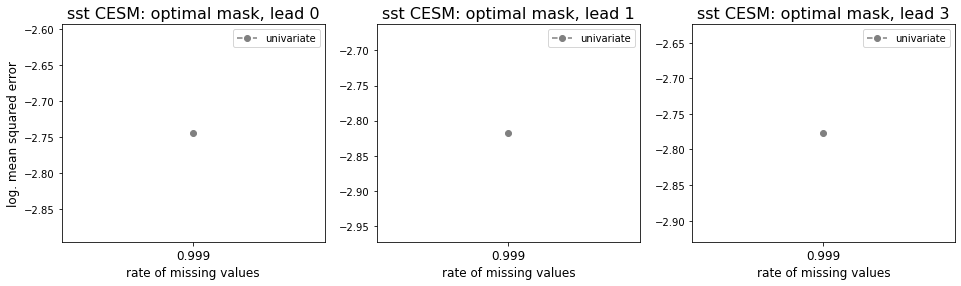

In [10]:
### Compare different input types for only optimal masks, separated by lead time.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 0
c = 0
d = 0

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over lead times (column):
for e in range(len(lead_times)):

    # Get current lead time:
    lead_time = lead_times[e]

    # Loop over input types:
    for a in range(len(input_types)):

        # Get current input type:
        input_type = input_types[a]

        # Plot minimum over seeds for optimal mask.
        axes[e].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
            label = input_type,
            marker = 'o', linestyle = linestyles[a],
        )

    # Add title, x-ticks and legend:    
    axes[e].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, lead '+str(lead_time), fontsize=16)
    axes[e].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[e].legend()        

    # Add x-label:
    axes[e].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if e == 0:          
        axes[e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

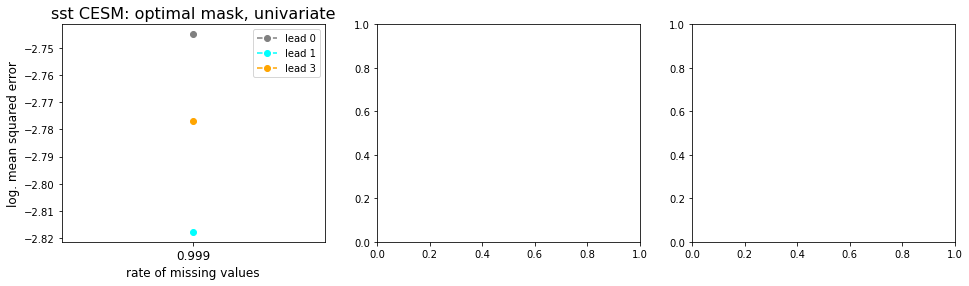

In [11]:
### Compare different lead times for only optimal masks, separated by input types.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 0
c = 0
d = 0

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over input types:
for a in range(len(input_types)):

    # Get current input type:
    input_type = input_types[a]

    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]

        # Plot minimum over seeds for optimal mask.
        axes[a].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
            label = 'lead '+str(lead_time),
            marker = 'o', linestyle = linestyles[e],
        )

    # Add title, x-ticks and legend:    
    axes[a].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, '+input_type, fontsize=16)
    axes[a].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[a].legend()        

    # Add x-label:
    axes[a].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if a == 0:          
        axes[a].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

### prec CESM (long runs)

IndexError: index 1 is out of bounds for axis 1 with size 1

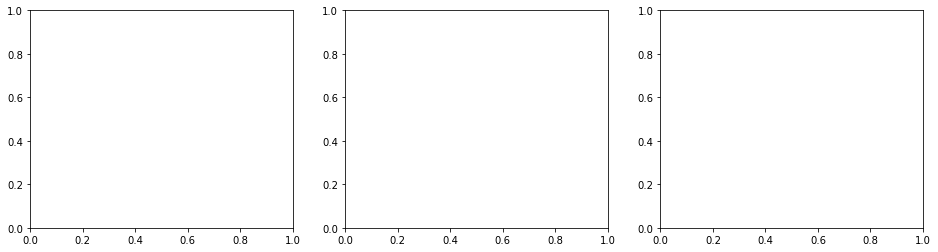

In [12]:
### Compare different input types for only optimal masks, separated by lead time.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 1
c = 0
d = 0

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over lead times (column):
for e in range(len(lead_times)):

    # Get current lead time:
    lead_time = lead_times[e]

    # Loop over input types:
    for a in range(len(input_types)):

        # Get current input type:
        input_type = input_types[a]

        # Plot minimum over seeds for optimal mask.
        axes[e].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
            label = input_type,
            marker = 'o', linestyle = linestyles[a],
        )

    # Add title, x-ticks and legend:    
    axes[e].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, lead '+str(lead_time), fontsize=16)
    axes[e].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[e].legend()        

    # Add x-label:
    axes[e].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if e == 0:          
        axes[e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

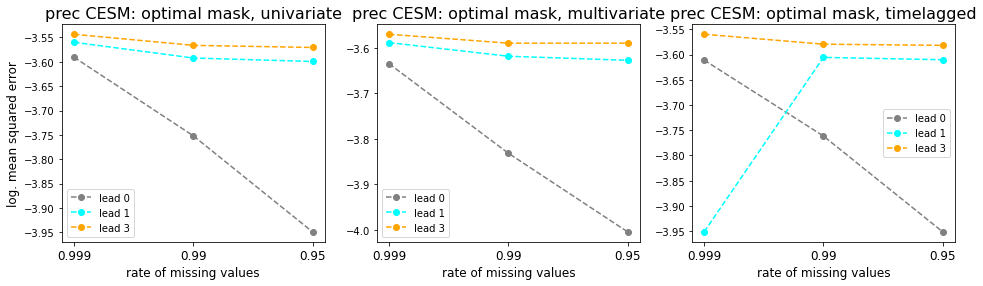

In [153]:
### Compare different lead times for only optimal masks, separated by input types.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 1
c = 0
d = 0

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over input types:
for a in range(len(input_types)):

    # Get current input type:
    input_type = input_types[a]

    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]

        # Plot minimum over seeds for optimal mask.
        axes[a].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
            label = 'lead '+str(lead_time),
            marker = 'o', linestyle = linestyles[e],
        )

    # Add title, x-ticks and legend:    
    axes[a].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, '+input_type, fontsize=16)
    axes[a].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[a].legend()        

    # Add x-label:
    axes[a].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if a == 0:          
        axes[a].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

### Check for Overfitting

In [13]:
# Check dimensions:
print('Dimensions:')
print('===========')
print('(a) input_types:    ',train_loss_all.shape[0],input_types)
print('(b) target_features:',train_loss_all.shape[1],target_features_short)
print('(c) sources:        ',train_loss_all.shape[2],sources)
print('(d) mask_types:     ',train_loss_all.shape[3],mask_types)
print('(e) lead_times:     ',train_loss_all.shape[4],lead_times)
print('(f) seeds:          ',train_loss_all.shape[5],seeds)
print('(g) missing_values: ',train_loss_all.shape[6],missing_values_all[0])

Dimensions:
(a) input_types:     1 ['univariate']
(b) target_features: 1 ['sst']
(c) sources:         2 ['CESM', 'FOCI']
(d) mask_types:      1 ['fixed']
(e) lead_times:      3 [0, 1, 3]
(f) seeds:           1 [1]
(g) missing_values:  1 [0.999]


### sst CESM, univariate

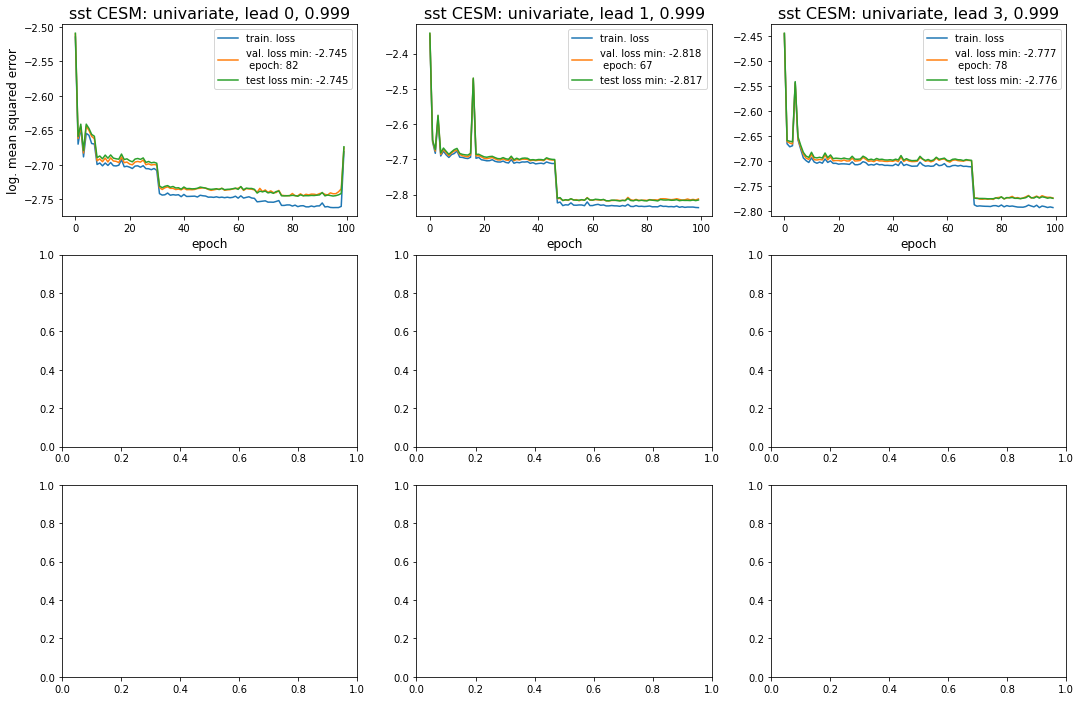

In [16]:
# Select input type (a), target feature (b), source (c), mask type (d) and seed (f):
a = 0
b = 0
c = 0
d = 0
f = 0

## Reload training and validation loss:

# Get current input type:
input_type = input_types[a]
    
# Get current target feature:
target_feature_short = target_features_short[b]

# Get current source:
source = sources[c]

# Get current mask type:
mask_type = mask_types[d]

# Get current seed:
seed = seeds[f]

# Plot training and validation loss for current all lead times (column) and all rates of missing values (rows):   
fig, axes = plt.subplots(3,3,figsize=(18,12))
        
# Loop over lead times:
for e in range(len(lead_times)):
    
    # Get current lead time:
    lead_time = lead_times[e]
    
    # Loop over missing values, according to mask type:
    for g in range(len(missing_values_all[d])):

        # Get current missing value:
        missing = missing_values_all[d][g]

        # Create path to stored loss:
        path_to_stored_loss = Path(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'
            + model_config
            + '_'
            + input_type
            + '_'
            + target_feature_short
            + '_'
            + source
            + '_'
            + mask_type
            + '_discrete_lead_'
            + str(lead_time)
            + '_seed_'
            + str(seed)
        )

        # Check, if loss file exists.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            if exists(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy') == True:
                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
                test_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'test_loss.npy')
            else:
                print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*1000)}')

        else:
            if exists(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy') == True:
                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
                test_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'test_loss.npy')
            else:
                print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*100)}')
        
        # Plot training, validation and test loss (omit epoch 0):
        axes[g,e].plot(
            np.log10(train_loss[1:]),
            label = 'train. loss',        
        )
        axes[g,e].plot(
            np.log10(val_loss[1:]),
            label = 'val. loss min: '+str(np.round(np.log10(val_loss[np.argmin(val_loss)]),3))+'\n epoch: '+str(np.argmin(val_loss)),
        )
        axes[g,e].plot(
            np.log10(test_loss[1:]),
            label = 'test loss min: '+str(np.round(np.log10(test_loss[np.argmin(val_loss)]),3)),
        )

        # Add title, x-ticks and legend:    
        axes[g,e].set_title(target_features_short[b]+' '+sources[c]+': '+input_type+', lead '+str(lead_time)+', '+str(missing), fontsize=16)
        axes[g,e].legend()        

        # Add x-label:
        if g == len(missing_values_all[d])-1:          
            axes[g,e].set_xlabel('epoch', fontsize=12)

        # Add y-label:
        if e == 0:          
            axes[g,e].set_ylabel('log. mean squared error', fontsize=12)

plt.show() 

### sst CESM, multivariate

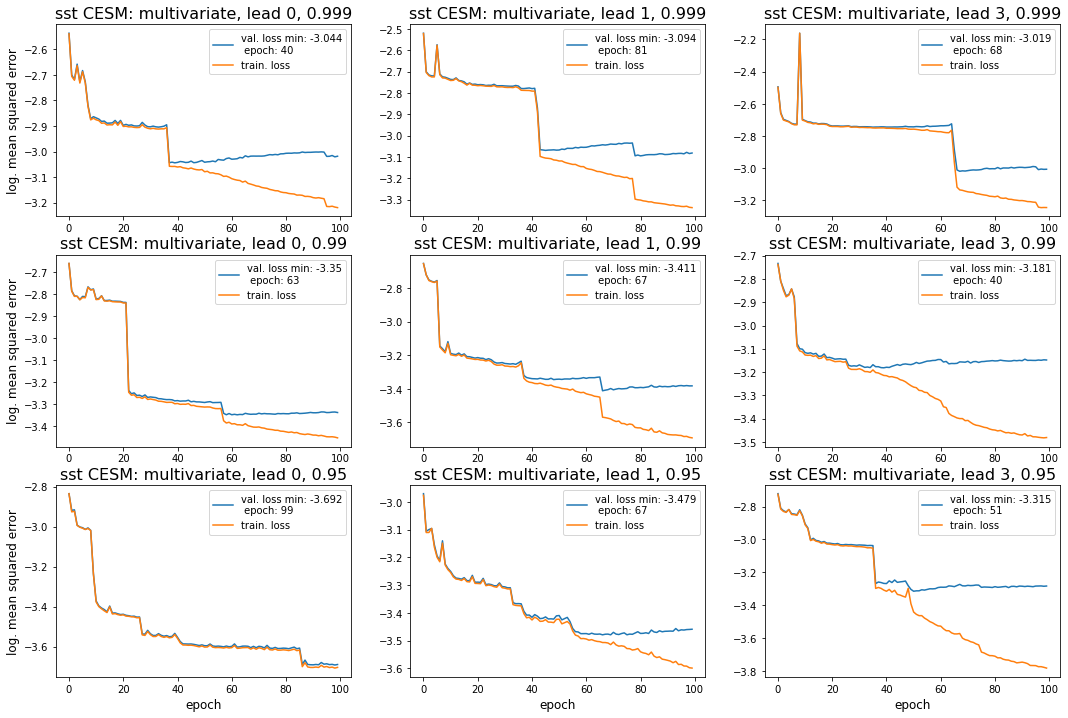

In [143]:
# Select input type (a), target feature (b), source (c), mask type (d) and seed (f):
a = 1
b = 0
c = 0
d = 0
f = 0

## Reload training and validation loss:

# Get current input type:
input_type = input_types[a]
    
# Get current target feature:
target_feature_short = target_features_short[b]

# Get current source:
source = sources[c]

# Get current mask type:
mask_type = mask_types[d]

# Get current seed:
seed = seeds[f]

# Plot training and validation loss for current all lead times (column) and all rates of missing values (rows):   
fig, axes = plt.subplots(3,3,figsize=(18,12))
        
# Loop over lead times:
for e in range(len(lead_times)):
    
    # Get current lead time:
    lead_time = lead_times[e]
    
    # Loop over missing values, according to mask type:
    for g in range(len(missing_values_all[d])):

        # Get current missing value:
        missing = missing_values_all[d][g]

        # Create path to stored loss:
        path_to_stored_loss = Path(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'
            + model_config
            + '_'
            + input_type
            + '_'
            + target_feature_short
            + '_'
            + source
            + '_'
            + mask_type
            + '_discrete_lead_'
            + str(lead_time)
            + '_seed_'
            + str(seed)
            + '_epochs_100'
        )

        # Check, if loss file exists.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            if exists(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy') == True:
                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
            else:
                print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*1000)}')

        else:
            if exists(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy') == True:
                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            else:
                print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*100)}')
        
        # Plot training and validation loss (omit epoch 0):
        axes[g,e].plot(
            np.log10(val_loss[1:]),
            label = 'val. loss min: '+str(np.round(np.log10(val_loss[np.argmin(val_loss)]),3))+'\n epoch: '+str(np.argmin(val_loss)),
        )
        axes[g,e].plot(
            np.log10(train_loss[1:]),
            label = 'train. loss',        
        )

        # Add title, x-ticks and legend:    
        axes[g,e].set_title(target_features_short[b]+' '+sources[c]+': '+input_type+', lead '+str(lead_time)+', '+str(missing), fontsize=16)
        axes[g,e].legend()        

        # Add x-label:
        if g == len(missing_values_all[d])-1:          
            axes[g,e].set_xlabel('epoch', fontsize=12)

        # Add y-label:
        if e == 0:          
            axes[g,e].set_ylabel('log. mean squared error', fontsize=12)

plt.show() 

### sst CESM, timelagged

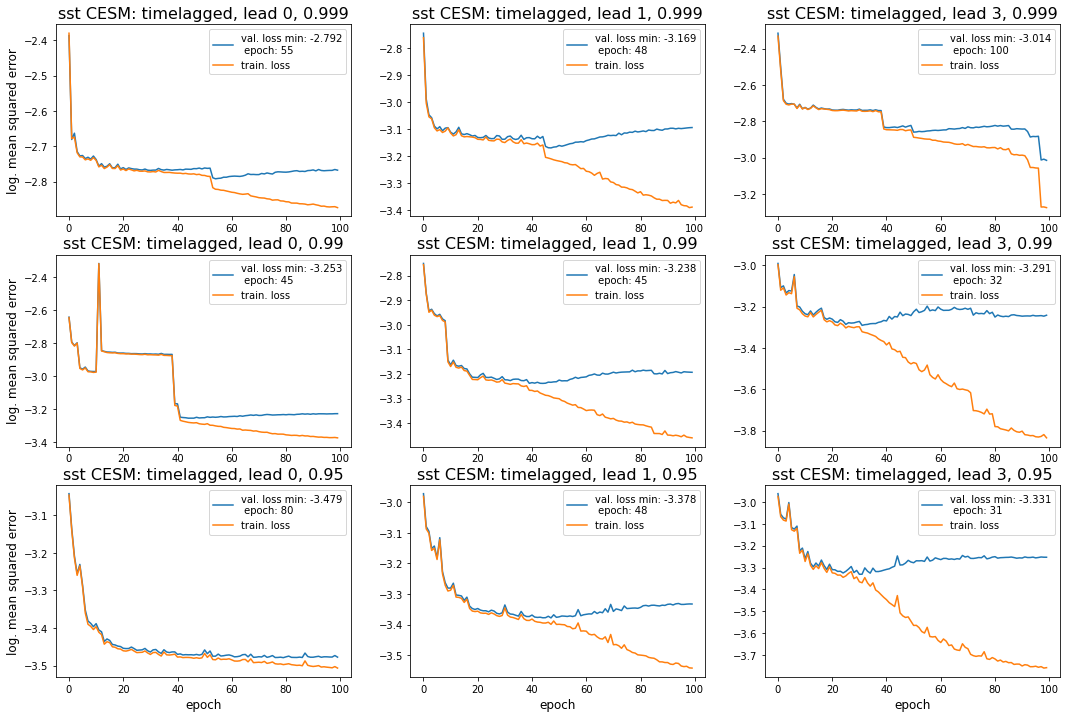

In [144]:
# Select input type (a), target feature (b), source (c), mask type (d) and seed (f):
a = 2
b = 0
c = 0
d = 0
f = 0

## Reload training and validation loss:

# Get current input type:
input_type = input_types[a]
    
# Get current target feature:
target_feature_short = target_features_short[b]

# Get current source:
source = sources[c]

# Get current mask type:
mask_type = mask_types[d]

# Get current seed:
seed = seeds[f]

# Plot training and validation loss for current all lead times (column) and all rates of missing values (rows):   
fig, axes = plt.subplots(3,3,figsize=(18,12))
        
# Loop over lead times:
for e in range(len(lead_times)):
    
    # Get current lead time:
    lead_time = lead_times[e]
    
    # Loop over missing values, according to mask type:
    for g in range(len(missing_values_all[d])):

        # Get current missing value:
        missing = missing_values_all[d][g]

        # Create path to stored loss:
        path_to_stored_loss = Path(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'
            + model_config
            + '_'
            + input_type
            + '_'
            + target_feature_short
            + '_'
            + source
            + '_'
            + mask_type
            + '_discrete_lead_'
            + str(lead_time)
            + '_seed_'
            + str(seed)
            + '_epochs_100'
        )

        # Check, if loss file exists.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            if exists(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy') == True:
                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
            else:
                print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*1000)}')

        else:
            if exists(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy') == True:
                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            else:
                print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*100)}')
        
        # Plot training and validation loss (omit epoch 0):
        axes[g,e].plot(
            np.log10(val_loss[1:]),
            label = 'val. loss min: '+str(np.round(np.log10(val_loss[np.argmin(val_loss)]),3))+'\n epoch: '+str(np.argmin(val_loss)),
        )
        axes[g,e].plot(
            np.log10(train_loss[1:]),
            label = 'train. loss',        
        )

        # Add title, x-ticks and legend:    
        axes[g,e].set_title(target_features_short[b]+' '+sources[c]+': '+input_type+', lead '+str(lead_time)+', '+str(missing), fontsize=16)
        axes[g,e].legend()        

        # Add x-label:
        if g == len(missing_values_all[d])-1:          
            axes[g,e].set_xlabel('epoch', fontsize=12)

        # Add y-label:
        if e == 0:          
            axes[g,e].set_ylabel('log. mean squared error', fontsize=12)

plt.show() 

### prec CESM, univariate

not available: GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_univariate_prec_CESM_optimal_discrete_lead_3_seed_1_epochs_100/missing_95


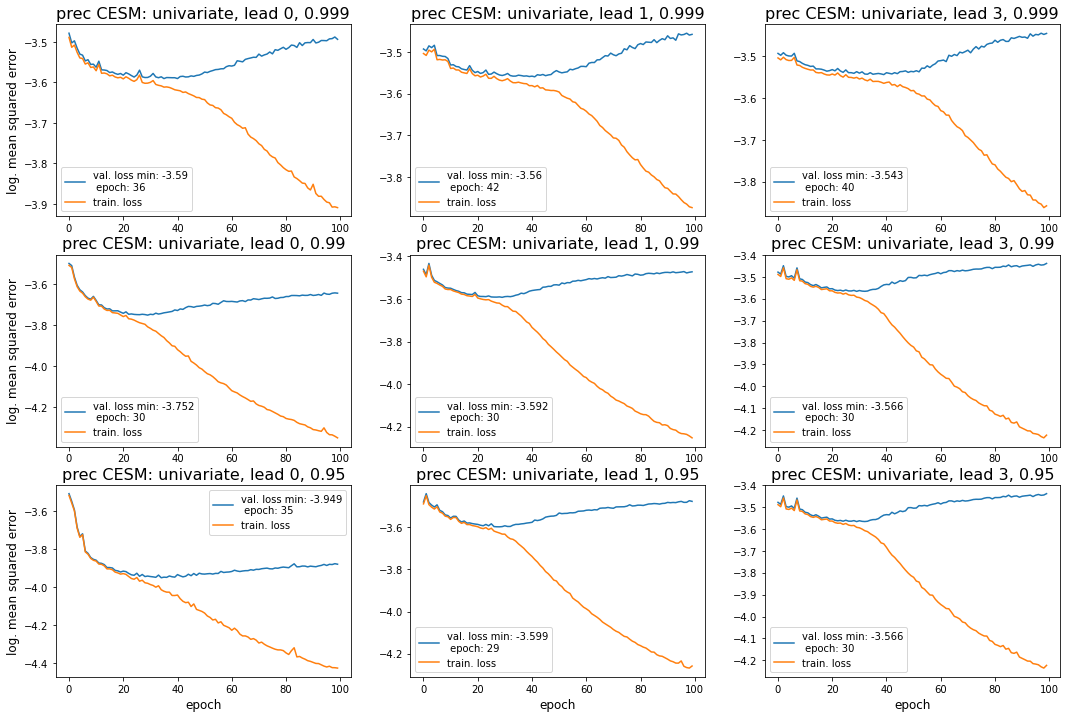

In [142]:
# Select input type (a), target feature (b), source (c), mask type (d) and seed (f):
a = 0
b = 1
c = 0
d = 0
f = 0

## Reload training and validation loss:

# Get current input type:
input_type = input_types[a]
    
# Get current target feature:
target_feature_short = target_features_short[b]

# Get current source:
source = sources[c]

# Get current mask type:
mask_type = mask_types[d]

# Get current seed:
seed = seeds[f]

# Plot training and validation loss for current all lead times (column) and all rates of missing values (rows):   
fig, axes = plt.subplots(3,3,figsize=(18,12))
        
# Loop over lead times:
for e in range(len(lead_times)):
    
    # Get current lead time:
    lead_time = lead_times[e]
    
    # Loop over missing values, according to mask type:
    for g in range(len(missing_values_all[d])):

        # Get current missing value:
        missing = missing_values_all[d][g]

        # Create path to stored loss:
        path_to_stored_loss = Path(
            'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'
            + model_config
            + '_'
            + input_type
            + '_'
            + target_feature_short
            + '_'
            + source
            + '_'
            + mask_type
            + '_discrete_lead_'
            + str(lead_time)
            + '_seed_'
            + str(seed)
            + '_epochs_100'
        )

        # Check, if loss file exists.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            if exists(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy') == True:
                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
            else:
                print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*1000)}')

        else:
            if exists(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy') == True:
                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            else:
                print('not available:',path_to_stored_loss / 'missing_' f'{int(missing*100)}')
        
        # Plot training and validation loss (omit epoch 0):
        axes[g,e].plot(
            np.log10(val_loss[1:]),
            label = 'val. loss min: '+str(np.round(np.log10(val_loss[np.argmin(val_loss)]),3))+'\n epoch: '+str(np.argmin(val_loss)),
        )
        axes[g,e].plot(
            np.log10(train_loss[1:]),
            label = 'train. loss',        
        )

        # Add title, x-ticks and legend:    
        axes[g,e].set_title(target_features_short[b]+' '+sources[c]+': '+input_type+', lead '+str(lead_time)+', '+str(missing), fontsize=16)
        axes[g,e].legend()        

        # Add x-label:
        if g == len(missing_values_all[d])-1:          
            axes[g,e].set_xlabel('epoch', fontsize=12)

        # Add y-label:
        if e == 0:          
            axes[g,e].set_ylabel('log. mean squared error', fontsize=12)

plt.show() 

### Experiments with U-Nets on CESM and FOCI slp and sst data to predict current ant future anomaly fields from sparse inputs

Go beyond [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x):
- **Univariate** inputs to predict current and future sst and prec fields, respectively, with lead times: 0, 1, 3 months.
- **Multivariate** inputs (slp, sst, z500, sat, sss, prec) to predict current and future sst and prec fields, respectively.
- **Timelagged** inputs (sst or prec) with lag 0..6 months to predict current and future sst and prec fields, respectively.

Inspect results from **short runs**, models trained over **10 epochs** with **learning rate 0.0001**.

In [1]:
import os
from os.path import exists
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

### Reload loss

In [3]:
## Define parameters:

# Number of epochs:
epochs = 10

# Model configuration:
model_config = 'predict_unet_4conv'

# Input type:
input_types = ['univariate', 'multivariate', 'timelagged']

# Target features:
target_features_short = ['sst', 'prec']

# Sources:
sources = ['CESM', 'FOCI']

# Mask types:
mask_types = ['fixed', 'variable', 'optimal']

# Lead times:
lead_times = [0, 1, 3]

# Seeds:
seeds = [1, 2, 3]

# Missing values, according to mask types:
missing_values_all = [
    [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.0],
    [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.0],
    [0.999, 0.99, 0.95]
]

In [4]:
# Initialize storages for reloades validation and training loss.
# Dimensions: (#input_types, #target_features, #sources, #mask_types, #lead_times, #seeds, #missing_values (max!), #epochs+1)
train_loss_all = np.zeros((len(input_types), 
                           len(target_features_short), 
                           len(sources),
                           len(mask_types),
                           len(lead_times),
                           len(seeds),
                           len(missing_values_all[0]),
                           epochs+1
                          ))
val_loss_all = np.zeros((len(input_types), 
                           len(target_features_short), 
                           len(sources),
                           len(mask_types),
                           len(lead_times),
                           len(seeds),
                           len(missing_values_all[0]),
                           epochs+1
                          ))

In [5]:
print('train_loss_all shape:',train_loss_all.shape)
print('  val_loss_all shape:',val_loss_all.shape)

train_loss_all shape: (3, 2, 2, 3, 3, 3, 7, 11)
  val_loss_all shape: (3, 2, 2, 3, 3, 3, 7, 11)


In [6]:
## Reload training and validation loss:

# Loop over input types:
for a in range(len(input_types)):
    
    # Get current input type:
    input_type = input_types[a]
    
    #Loop over target features:
    for b in range(len(target_features_short)):
        
        # Get current target feature:
        target_feature_short = target_features_short[b]
        
        # Loop over sources:
        for c in range(len(sources)):
            
            # Get current source:
            source = sources[c]
            
            # Loop over mask types:
            for d in range(len(mask_types)):

                # Get current mask type:
                mask_type = mask_types[d]

                # Loop over lead times:
                for e in range(len(lead_times)):
                    
                    # Get current lead time:
                    lead_time = lead_times[e]
                    
                    # Loop over seeds:
                    for f in range(len(seeds)):
                        
                        # Get current seed:
                        seed = seeds[f]
                        
                        # Loop over missing values, according to mask type:
                        for g in range(len(missing_values_all[d])):
                            
                            # Get current missing value:
                            missing = missing_values_all[d][g]
                            
                            # Create path to stored loss:
                            path_to_stored_loss = Path(
                                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'
                                + model_config
                                + '_'
                                + input_type
                                + '_'
                                + target_feature_short
                                + '_'
                                + source
                                + '_'
                                + mask_type
                                + '_discrete_lead_'
                                + str(lead_time)
                                + '_seed_'
                                + str(seed)
                            )
                            
                            # Check, if loss file exists.
                            # Rel. amount of missing values = 0.999 requires special treatment:
                            if missing==0.999:
                                #if exists(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy') == False:
                                #    print(path_to_stored_loss / 'missing_' f'{int(missing*1000)}')
                                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
                                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
                            else:
                                #if exists(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy') == False:
                                #    print(path_to_stored_loss / 'missing_' f'{int(missing*100)}')
                                train_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
                                val_loss = np.load(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')

                            # Store final train and validation loss:
                            train_loss_all[a,b,c,d,e,f,g,:] = train_loss
                            val_loss_all[a,b,c,d,e,f,g,:] = val_loss

In [7]:
# Get minimum loss over epochs:
train_loss_min = np.min(train_loss_all,axis=-1)
val_loss_min = np.min(val_loss_all,axis=-1)

# Get minimum and mean over seeds:
train_loss_min_min = np.min(train_loss_min,-2)
val_loss_min_min = np.min(val_loss_min,-2)
train_loss_min_mean = np.mean(train_loss_min,-2)
val_loss_min_mean = np.mean(val_loss_min,-2)

# Check dimensions:
print('Dimensions:')
print('===========')
print('input_types:    ',train_loss_min_min.shape[0],input_types)
print('target_features:',train_loss_min_min.shape[1],target_features_short)
print('sources:        ',train_loss_min_min.shape[2],sources)
print('mask_types:     ',train_loss_min_min.shape[3],mask_types)
print('lead_times:     ',train_loss_min_min.shape[4],lead_times)
print('missing_values: ',train_loss_min_min.shape[5],missing_values_all[0])

Dimensions:
input_types:     3 ['univariate', 'multivariate', 'timelagged']
target_features: 2 ['sst', 'prec']
sources:         2 ['CESM', 'FOCI']
mask_types:      3 ['fixed', 'variable', 'optimal']
lead_times:      3 [0, 1, 3]
missing_values:  7 [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.0]


### sst CESM

/tmp/ipykernel_2888336/2345833038.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2345833038.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2345833038.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2345833038.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2345833038.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2345833038.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2345833038.py:42: RuntimeWarning: divide by zero encountered in log10
 

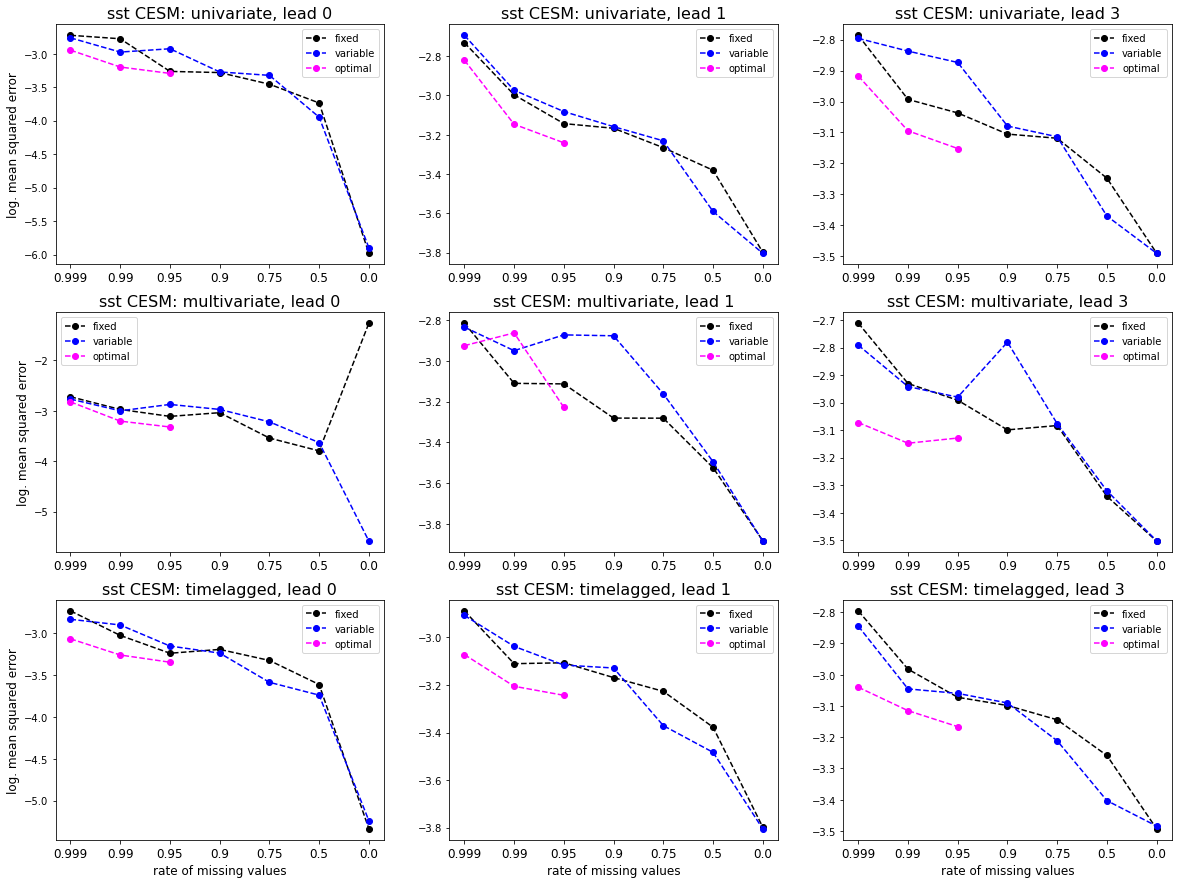

In [8]:
### Compare different mask types, separately for each input type and lead time.

## Minimum VALIDATION loss over epochs.
## Mean over seeds for fixed and variable masks.
## Minimum over seeds for optimal mask.

# Select target feature (b) and source (c):
b = 0
c = 0

# Set colors for individual experiments:
colors = ['black', 'blue', 'magenta']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(3,3,figsize=(20,15))

# Loop over input types (row):
for a in range(len(input_types)):
    
    # Get current input type:
    input_type = input_types[a]
    
    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]
        
        # Loop over mask types:
        for d in range(len(mask_types)):
            
            # Get current mask type:
            mask_type = mask_types[d]
            
            
            # Plot mean over seeds for fixed and variable masks.
            # Plot minimum over seeds for optimal mask.
            if mask_type=='optimal':
                
                axes[a,e].plot(
                    np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
                    label = mask_type,
                    marker = 'o', linestyle = linestyles[d],
                )
                
            else:
                axes[a,e].plot(
                    np.log10(val_loss_min_mean[a,b,c,d,e]), color=colors[d],
                    label = mask_type,
                    marker = 'o', linestyle = linestyles[d],
                )

        # Add title, x-ticks and legend:    
        axes[a,e].set_title(target_features_short[b]+' '+sources[c]+': '+input_type+', lead '+str(lead_time), fontsize=16)
        axes[a,e].set_xticks(np.arange(0, len(missing_values_all[0]), step=1), missing_values_all[0], fontsize=12)
        axes[a,e].legend()        
        
        # Add x-label:
        if a == len(input_types)-1:          
            axes[a,e].set_xlabel('rate of missing values', fontsize=12)
        
        # Add y-label:
        if e == 0:          
            axes[a,e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

/tmp/ipykernel_2888336/3898296356.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3898296356.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3898296356.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3898296356.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3898296356.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3898296356.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3898296356.py:33: RuntimeWarning: divide by zero encountered in log10
 

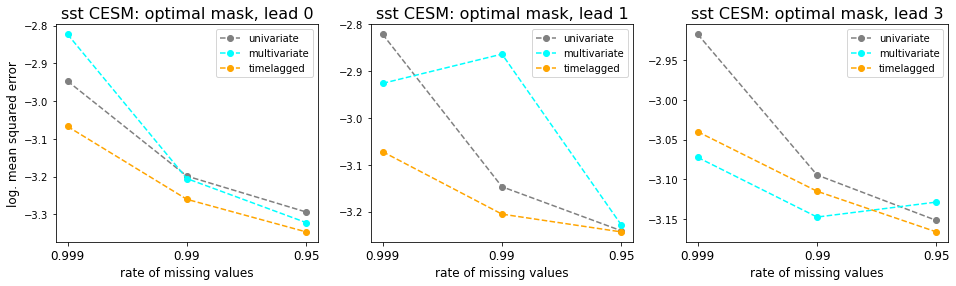

In [9]:
### Compare different input types for only optimal masks, separated by lead time.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 0
c = 0
d = 2

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over lead times (column):
for e in range(len(lead_times)):

    # Get current lead time:
    lead_time = lead_times[e]

    # Loop over input types:
    for a in range(len(input_types)):

        # Get current input type:
        input_type = input_types[a]

        # Plot minimum over seeds for optimal mask.
        axes[e].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
            label = input_type,
            marker = 'o', linestyle = linestyles[a],
        )

    # Add title, x-ticks and legend:    
    axes[e].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, lead '+str(lead_time), fontsize=16)
    axes[e].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[e].legend()        

    # Add x-label:
    axes[e].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if e == 0:          
        axes[e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

/tmp/ipykernel_2888336/555484728.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/555484728.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/555484728.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/555484728.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/555484728.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/555484728.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/555484728.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log

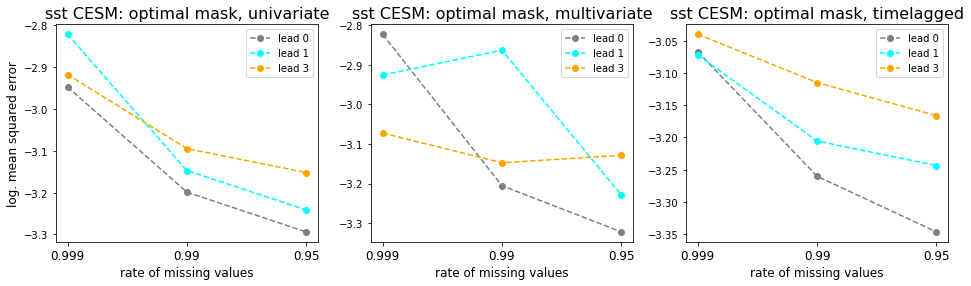

In [10]:
### Compare different lead times for only optimal masks, separated by input types.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 0
c = 0
d = 2

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over input types:
for a in range(len(input_types)):

    # Get current input type:
    input_type = input_types[a]

    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]

        # Plot minimum over seeds for optimal mask.
        axes[a].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
            label = 'lead '+str(lead_time),
            marker = 'o', linestyle = linestyles[e],
        )

    # Add title, x-ticks and legend:    
    axes[a].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, '+input_type, fontsize=16)
    axes[a].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[a].legend()        

    # Add x-label:
    axes[a].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if a == 0:          
        axes[a].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

### sst FOCI

/tmp/ipykernel_2888336/4079427608.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/4079427608.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/4079427608.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/4079427608.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/4079427608.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/4079427608.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/4079427608.py:42: RuntimeWarning: divide by zero encountered in log10
 

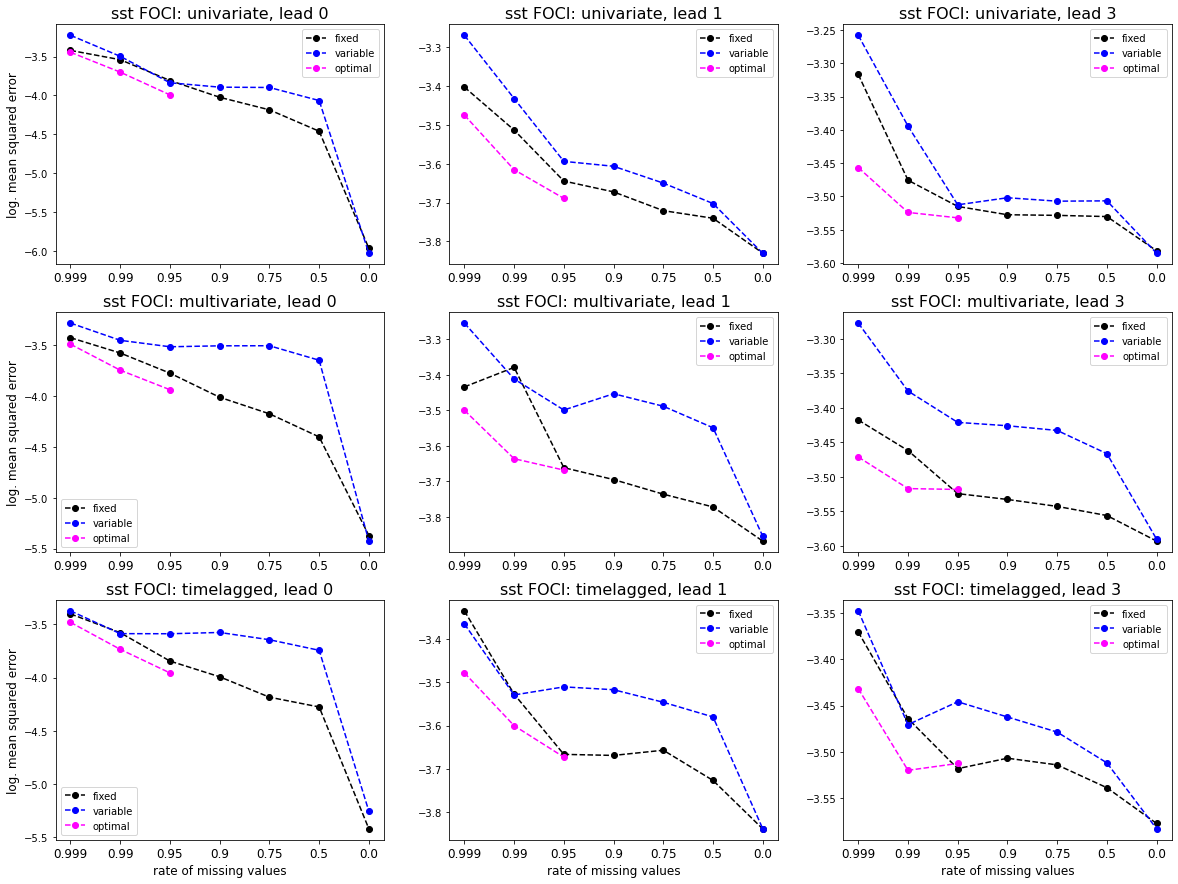

In [11]:
### Compare different mask types, separately for each input type and lead time.

## Minimum VALIDATION loss over epochs.
## Mean over seeds for fixed and variable masks.
## Minimum over seeds for optimal mask.

# Select target feature (b) and source (c):
b = 0
c = 1

# Set colors for individual experiments:
colors = ['black', 'blue', 'magenta']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(3,3,figsize=(20,15))

# Loop over input types (row):
for a in range(len(input_types)):
    
    # Get current input type:
    input_type = input_types[a]
    
    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]
        
        # Loop over mask types:
        for d in range(len(mask_types)):
            
            # Get current mask type:
            mask_type = mask_types[d]
            
            
            # Plot mean over seeds for fixed and variable masks.
            # Plot minimum over seeds for optimal mask.
            if mask_type=='optimal':
                
                axes[a,e].plot(
                    np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
                    label = mask_type,
                    marker = 'o', linestyle = linestyles[d],
                )
                
            else:
                axes[a,e].plot(
                    np.log10(val_loss_min_mean[a,b,c,d,e]), color=colors[d],
                    label = mask_type,
                    marker = 'o', linestyle = linestyles[d],
                )

        # Add title, x-ticks and legend:    
        axes[a,e].set_title(target_features_short[b]+' '+sources[c]+': '+input_type+', lead '+str(lead_time), fontsize=16)
        axes[a,e].set_xticks(np.arange(0, len(missing_values_all[0]), step=1), missing_values_all[0], fontsize=12)
        axes[a,e].legend()        
        
        # Add x-label:
        if a == len(input_types)-1:          
            axes[a,e].set_xlabel('rate of missing values', fontsize=12)
        
        # Add y-label:
        if e == 0:          
            axes[a,e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

/tmp/ipykernel_2888336/1977841775.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/1977841775.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/1977841775.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/1977841775.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/1977841775.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/1977841775.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/1977841775.py:33: RuntimeWarning: divide by zero encountered in log10
 

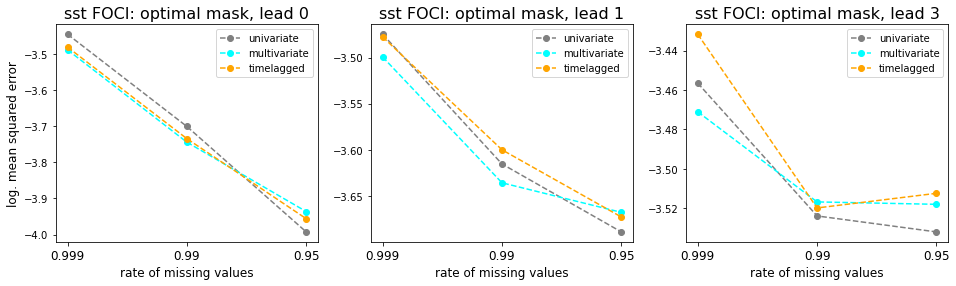

In [12]:
### Compare different input types for only optimal masks, separated by lead time.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 0
c = 1
d = 2

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over lead times (column):
for e in range(len(lead_times)):

    # Get current lead time:
    lead_time = lead_times[e]

    # Loop over input types:
    for a in range(len(input_types)):

        # Get current input type:
        input_type = input_types[a]

        # Plot minimum over seeds for optimal mask.
        axes[e].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
            label = input_type,
            marker = 'o', linestyle = linestyles[a],
        )

    # Add title, x-ticks and legend:    
    axes[e].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, lead '+str(lead_time), fontsize=16)
    axes[e].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[e].legend()        

    # Add x-label:
    axes[e].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if e == 0:          
        axes[e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

/tmp/ipykernel_2888336/532583632.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/532583632.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/532583632.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/532583632.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/532583632.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/532583632.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/532583632.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log

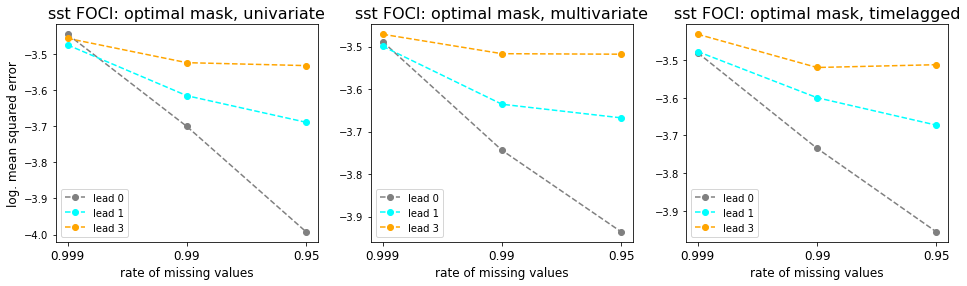

In [13]:
### Compare different lead times for only optimal masks, separated by input types.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 0
c = 1
d = 2

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over input types:
for a in range(len(input_types)):

    # Get current input type:
    input_type = input_types[a]

    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]

        # Plot minimum over seeds for optimal mask.
        axes[a].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
            label = 'lead '+str(lead_time),
            marker = 'o', linestyle = linestyles[e],
        )

    # Add title, x-ticks and legend:    
    axes[a].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, '+input_type, fontsize=16)
    axes[a].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[a].legend()        

    # Add x-label:
    axes[a].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if a == 0:          
        axes[a].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

### prec CESM

/tmp/ipykernel_2888336/1116338574.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/1116338574.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/1116338574.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/1116338574.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/1116338574.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/1116338574.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/1116338574.py:42: RuntimeWarning: divide by zero encountered in log10
 

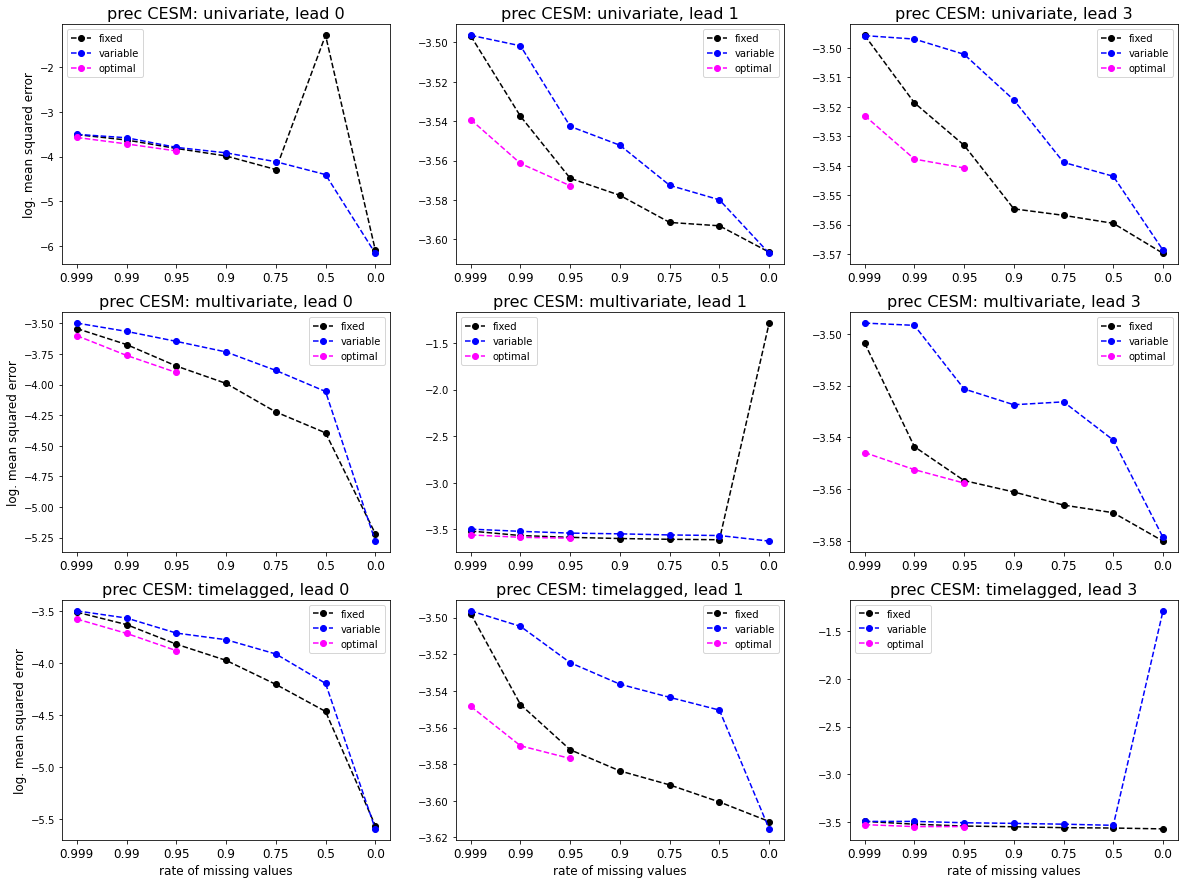

In [14]:
### Compare different mask types, separately for each input type and lead time.

## Minimum VALIDATION loss over epochs.
## Mean over seeds for fixed and variable masks.
## Minimum over seeds for optimal mask.

# Select target feature (b) and source (c):
b = 1
c = 0

# Set colors for individual experiments:
colors = ['black', 'blue', 'magenta']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(3,3,figsize=(20,15))

# Loop over input types (row):
for a in range(len(input_types)):
    
    # Get current input type:
    input_type = input_types[a]
    
    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]
        
        # Loop over mask types:
        for d in range(len(mask_types)):
            
            # Get current mask type:
            mask_type = mask_types[d]
            
            
            # Plot mean over seeds for fixed and variable masks.
            # Plot minimum over seeds for optimal mask.
            if mask_type=='optimal':
                
                axes[a,e].plot(
                    np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
                    label = mask_type,
                    marker = 'o', linestyle = linestyles[d],
                )
                
            else:
                axes[a,e].plot(
                    np.log10(val_loss_min_mean[a,b,c,d,e]), color=colors[d],
                    label = mask_type,
                    marker = 'o', linestyle = linestyles[d],
                )

        # Add title, x-ticks and legend:    
        axes[a,e].set_title(target_features_short[b]+' '+sources[c]+': '+input_type+', lead '+str(lead_time), fontsize=16)
        axes[a,e].set_xticks(np.arange(0, len(missing_values_all[0]), step=1), missing_values_all[0], fontsize=12)
        axes[a,e].legend()        
        
        # Add x-label:
        if a == len(input_types)-1:          
            axes[a,e].set_xlabel('rate of missing values', fontsize=12)
        
        # Add y-label:
        if e == 0:          
            axes[a,e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

/tmp/ipykernel_2888336/3548517837.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3548517837.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3548517837.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3548517837.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3548517837.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3548517837.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/3548517837.py:33: RuntimeWarning: divide by zero encountered in log10
 

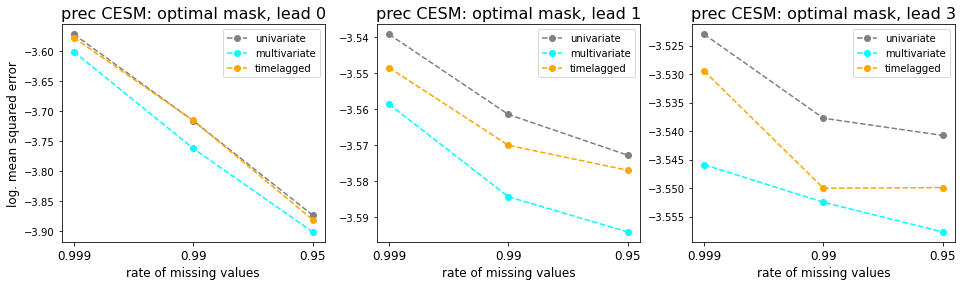

In [15]:
### Compare different input types for only optimal masks, separated by lead time.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 1
c = 0
d = 2

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over lead times (column):
for e in range(len(lead_times)):

    # Get current lead time:
    lead_time = lead_times[e]

    # Loop over input types:
    for a in range(len(input_types)):

        # Get current input type:
        input_type = input_types[a]

        # Plot minimum over seeds for optimal mask.
        axes[e].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
            label = input_type,
            marker = 'o', linestyle = linestyles[a],
        )

    # Add title, x-ticks and legend:    
    axes[e].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, lead '+str(lead_time), fontsize=16)
    axes[e].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[e].legend()        

    # Add x-label:
    axes[e].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if e == 0:          
        axes[e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

/tmp/ipykernel_2888336/593711585.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/593711585.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/593711585.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/593711585.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/593711585.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/593711585.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/593711585.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log

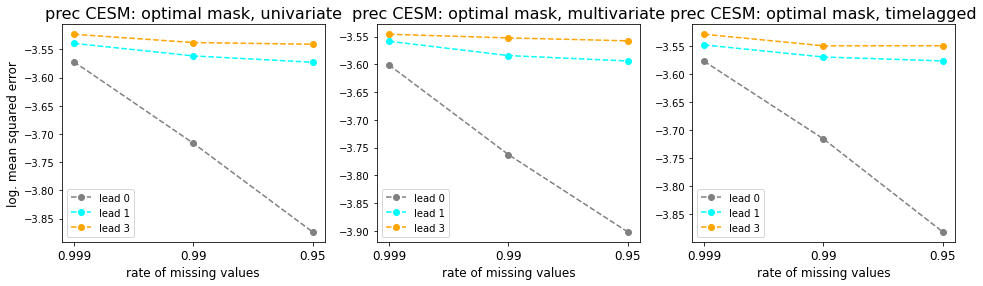

In [16]:
### Compare different lead times for only optimal masks, separated by input types.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 1
c = 0
d = 2

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over input types:
for a in range(len(input_types)):

    # Get current input type:
    input_type = input_types[a]

    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]

        # Plot minimum over seeds for optimal mask.
        axes[a].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
            label = 'lead '+str(lead_time),
            marker = 'o', linestyle = linestyles[e],
        )

    # Add title, x-ticks and legend:    
    axes[a].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, '+input_type, fontsize=16)
    axes[a].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[a].legend()        

    # Add x-label:
    axes[a].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if a == 0:          
        axes[a].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

### prec FOCI

/tmp/ipykernel_2888336/2618562123.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2618562123.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2618562123.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2618562123.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2618562123.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2618562123.py:42: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
/tmp/ipykernel_2888336/2618562123.py:42: RuntimeWarning: divide by zero encountered in log10
 

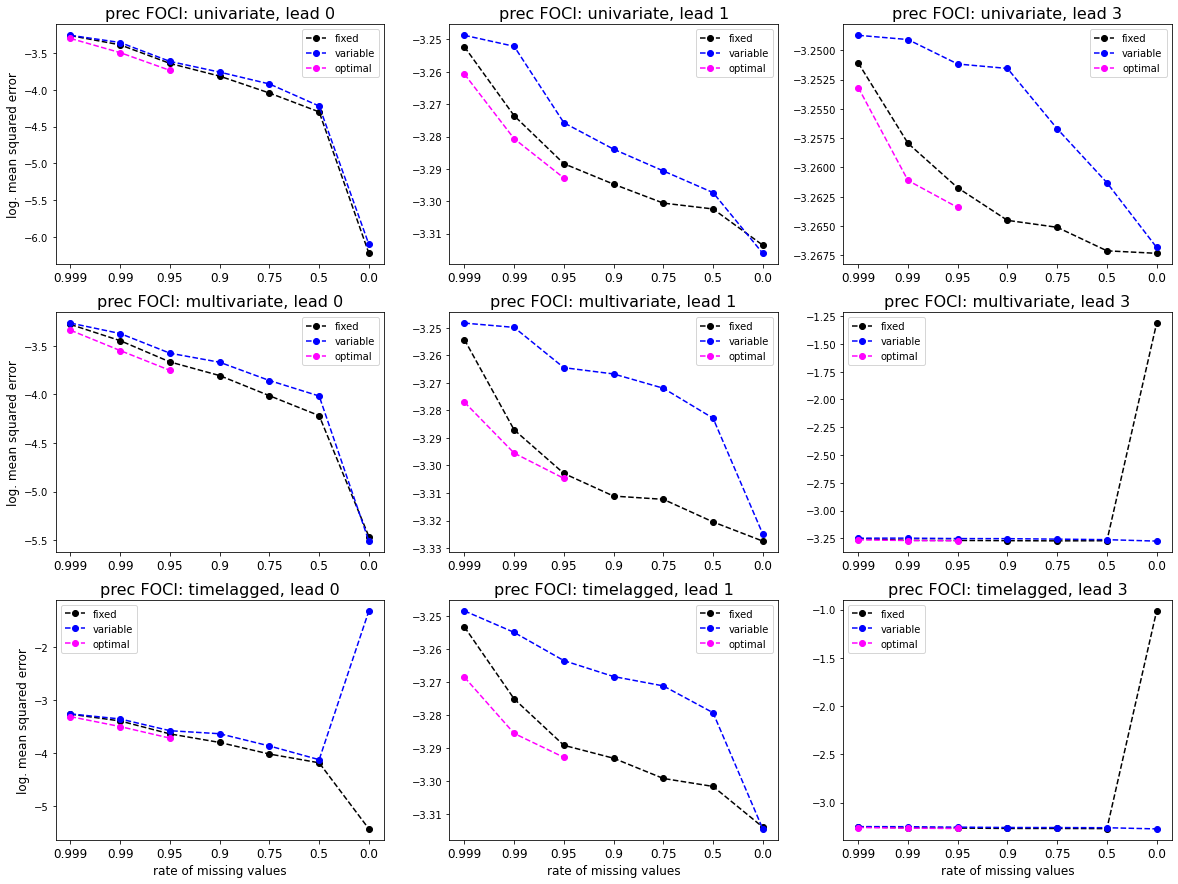

In [18]:
### Compare different mask types, separately for each input type and lead time.

## Minimum VALIDATION loss over epochs.
## Mean over seeds for fixed and variable masks.
## Minimum over seeds for optimal mask.

# Select target feature (b) and source (c):
b = 1
c = 1

# Set colors for individual experiments:
colors = ['black', 'blue', 'magenta']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(3,3,figsize=(20,15))

# Loop over input types (row):
for a in range(len(input_types)):
    
    # Get current input type:
    input_type = input_types[a]
    
    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]
        
        # Loop over mask types:
        for d in range(len(mask_types)):
            
            # Get current mask type:
            mask_type = mask_types[d]
            
            
            # Plot mean over seeds for fixed and variable masks.
            # Plot minimum over seeds for optimal mask.
            if mask_type=='optimal':
                
                axes[a,e].plot(
                    np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[d],
                    label = mask_type,
                    marker = 'o', linestyle = linestyles[d],
                )
                
            else:
                axes[a,e].plot(
                    np.log10(val_loss_min_mean[a,b,c,d,e]), color=colors[d],
                    label = mask_type,
                    marker = 'o', linestyle = linestyles[d],
                )

        # Add title, x-ticks and legend:    
        axes[a,e].set_title(target_features_short[b]+' '+sources[c]+': '+input_type+', lead '+str(lead_time), fontsize=16)
        axes[a,e].set_xticks(np.arange(0, len(missing_values_all[0]), step=1), missing_values_all[0], fontsize=12)
        axes[a,e].legend()        
        
        # Add x-label:
        if a == len(input_types)-1:          
            axes[a,e].set_xlabel('rate of missing values', fontsize=12)
        
        # Add y-label:
        if e == 0:          
            axes[a,e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

/tmp/ipykernel_2888336/4220507893.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/4220507893.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/4220507893.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/4220507893.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/4220507893.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/4220507893.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
/tmp/ipykernel_2888336/4220507893.py:33: RuntimeWarning: divide by zero encountered in log10
 

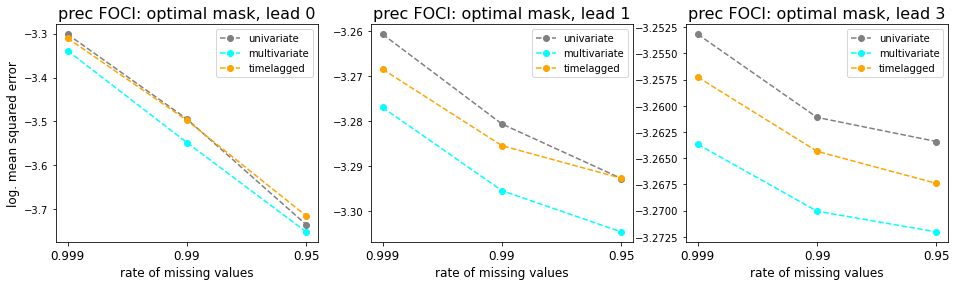

In [20]:
### Compare different input types for only optimal masks, separated by lead time.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 1
c = 1
d = 2

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over lead times (column):
for e in range(len(lead_times)):

    # Get current lead time:
    lead_time = lead_times[e]

    # Loop over input types:
    for a in range(len(input_types)):

        # Get current input type:
        input_type = input_types[a]

        # Plot minimum over seeds for optimal mask.
        axes[e].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[a],
            label = input_type,
            marker = 'o', linestyle = linestyles[a],
        )

    # Add title, x-ticks and legend:    
    axes[e].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, lead '+str(lead_time), fontsize=16)
    axes[e].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[e].legend()        

    # Add x-label:
    axes[e].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if e == 0:          
        axes[e].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

/tmp/ipykernel_2888336/3972716223.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/3972716223.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/3972716223.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/3972716223.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/3972716223.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/3972716223.py:33: RuntimeWarning: divide by zero encountered in log10
  np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
/tmp/ipykernel_2888336/3972716223.py:33: RuntimeWarning: divide by zero encountered in log10
 

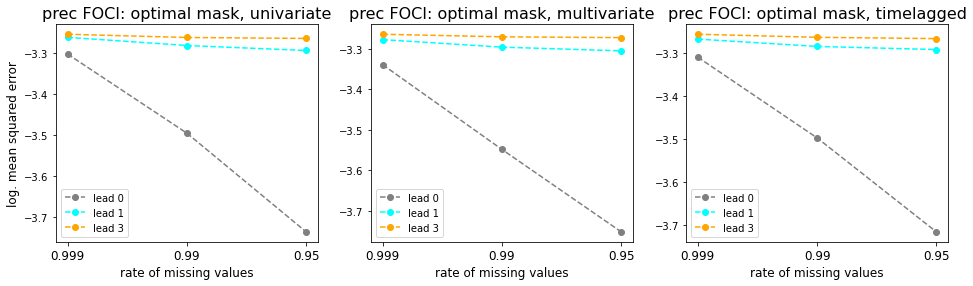

In [21]:
### Compare different lead times for only optimal masks, separated by input types.

## Minimum VALIDATION loss over epochs.
## Minimum over seeds for optimal mask.

# Select target feature (b), source (c) and mask type (d):
b = 1
c = 1
d = 2

# Set colors for individual experiments:
colors = ['grey', 'cyan', 'orange']
linestyles = ['--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,3,figsize=(16,4))

  
# Loop over input types:
for a in range(len(input_types)):

    # Get current input type:
    input_type = input_types[a]

    # Loop over lead times (column):
    for e in range(len(lead_times)):

        # Get current lead time:
        lead_time = lead_times[e]

        # Plot minimum over seeds for optimal mask.
        axes[a].plot(
            np.log10(val_loss_min_min[a,b,c,d,e]), color=colors[e],
            label = 'lead '+str(lead_time),
            marker = 'o', linestyle = linestyles[e],
        )

    # Add title, x-ticks and legend:    
    axes[a].set_title(target_features_short[b]+' '+sources[c]+': optimal mask, '+input_type, fontsize=16)
    axes[a].set_xticks(np.arange(0, len(missing_values_all[d]), step=1), missing_values_all[d], fontsize=12)
    axes[a].legend()        

    # Add x-label:
    axes[a].set_xlabel('rate of missing values', fontsize=12)

    # Add y-label:
    if a == 0:          
        axes[a].set_ylabel('log. mean squared error', fontsize=12)
        
plt.show() 

In [3]:
## Define parameters:

# Number of epochs:
epochs = 10

# Model configuration:
model_config = 'predict_unet_4conv'

# Input type:
input_types = ['univariate', 'multivariate', 'timelagged']

# Target features:
target_features_short = ['prec']

# Sources:
sources = ['FOCI']

# Mask types:
mask_types = ['fixed', 'variable', 'optimal']

# Lead times:
lead_times = [0, 1, 3]

# Seeds:
seeds = [1, 2, 3]

# Missing values, according to mask types:
missing_values_all = [
    [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.0],
    [0.999, 0.99, 0.95, 0.9, 0.75, 0.5, 0.0],
    [0.999, 0.99, 0.95]
]

In [4]:
## Reload training and validation loss:

# Loop over input types:
for a in range(len(input_types)):
    
    # Get current input type:
    input_type = input_types[a]
    
    #Loop over target features:
    for b in range(len(target_features_short)):
        
        # Get current target feature:
        target_feature_short = target_features_short[b]
        
        # Loop over sources:
        for c in range(len(sources)):
            
            # Get current source:
            source = sources[c]
            
            # Loop over mask types:
            for d in range(len(mask_types)):

                # Get current mask type:
                mask_type = mask_types[d]

                # Loop over lead times:
                for e in range(len(lead_times)):
                    
                    # Get current lead time:
                    lead_time = lead_times[e]
                    
                    # Loop over seeds:
                    for f in range(len(seeds)):
                        
                        # Get current seed:
                        seed = seeds[f]
                        
                        # Loop over missing values, according to mask type:
                        for g in range(len(missing_values_all[d])):
                            
                            # Get current missing value:
                            missing = missing_values_all[d][g]
                            
                            # Create path to stored loss:
                            path_to_stored_loss = Path(
                                'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'
                                + model_config
                                + '_'
                                + input_type
                                + '_'
                                + target_feature_short
                                + '_'
                                + source
                                + '_'
                                + mask_type
                                + '_discrete_lead_'
                                + str(lead_time)
                                + '_seed_'
                                + str(seed)
                            )
                            
                            # Check, if loss file exists.
                            # Rel. amount of missing values = 0.999 requires special treatment:
                            if missing==0.999:
                                if exists(path_to_stored_loss / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy') == False:
                                    print(path_to_stored_loss / 'missing_' f'{int(missing*1000)}')
                            else:
                                if exists(path_to_stored_loss / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy') == False:
                                    print(path_to_stored_loss / 'missing_' f'{int(missing*100)}')
                                

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_FOCI_fixed_discrete_lead_3_seed_2/missing_90
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_FOCI_fixed_discrete_lead_3_seed_2/missing_75
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_FOCI_fixed_discrete_lead_3_seed_2/missing_50
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_FOCI_fixed_discrete_lead_3_seed_2/missing_0
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_FOCI_fixed_discrete_lead_3_seed_3/missing_999
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_FOCI_fixed_discrete_lead_3_seed_3/missing_99
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/predict_unet_4conv_multivariate_prec_FOCI_fixed_discrete_lead_3_seed_3/missing_95

In [82]:
base_path_string = 'GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'
paths = [
#     Path(base_path_string+'predict_unet_5conv_univariate_sst_FOCI_fixed_discrete_lead_0_seed_1'),
#     Path(base_path_string+'predict_unet_5conv_univariate_sst_FOCI_fixed_discrete_lead_0_seed_1_medium_lr'),
#     Path(base_path_string+'predict_unet_5conv_univariate_sst_FOCI_fixed_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_5conv_univariate_sst_FOCI_fixed_discrete_lead_3_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_fixed_discrete_lead_0_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_fixed_discrete_lead_0_seed_1_medium_lr'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_fixed_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_multivariate_sst_FOCI_fixed_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_multivariate_sst_FOCI_variable_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_multivariate_sst_FOCI_optimal_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_timelagged_sst_FOCI_fixed_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_timelagged_sst_FOCI_variable_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_fixed_discrete_lead_3_seed_1'),
     Path(base_path_string+'predict_unet_4conv_multivariate_sst_FOCI_fixed_discrete_lead_3_seed_1'),
     Path(base_path_string+'predict_unet_4conv_multivariate_sst_FOCI_variable_discrete_lead_3_seed_1'),    
     Path(base_path_string+'predict_unet_4conv_multivariate_sst_FOCI_optimal_discrete_lead_3_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_timelagged_sst_FOCI_fixed_discrete_lead_3_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_timelagged_sst_FOCI_variable_discrete_lead_3_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_variable_discrete_lead_0_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_variable_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_variable_discrete_lead_3_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_optimal_discrete_lead_0_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_optimal_discrete_lead_1_seed_1'),
#     Path(base_path_string+'predict_unet_4conv_univariate_sst_FOCI_optimal_discrete_lead_3_seed_1'),
    
    
]

shortnames = [
#     '5conv, lead 0',
#     '5conv, lead 0, medium lr',
#     '5conv, lead 1',
#     '5conv, lead 3',
#     '4conv, lead 0',
#     '4conv, lead 0, medium lr',
#     '4conv, lead 1',
#     '4conv, lead 1, multivariate',
#     '4conv, lead 1, multivariate, variable',
#     '4conv, lead 1, multivariate, optimal',
#     '4conv, lead 1, timelagged',
#     '4conv, lead 1, timelagged, variable',
#     '4conv, lead 3',
     '4conv, lead 3, multivariate',
     '4conv, lead 3, multivariate, variable',
     '4conv, lead 3, multivariate, optimal',
#     '4conv, lead 3, timelagged',   
#     '4conv, lead 3, timelagged, variable',   
#     '4conv, lead 0, univariate, variable',
#     '4conv, lead 1, univariate, variable',
#     '4conv, lead 3, univariate, variable',
#     '4conv, lead 0, univariate, optimal',
#     '4conv, lead 1, univariate, optimal',
#     '4conv, lead 3, univariate, optimal',
]
    

In [83]:
epochs = 10
missing_values = [
    0.999,
    0.99,
    0.95,
#     0.9,
#     0.75,
#     0.5,
#     0.0,
]

In [84]:
# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss

In [85]:
np.min(train_loss_final_all,axis=-1).shape

(3, 3)

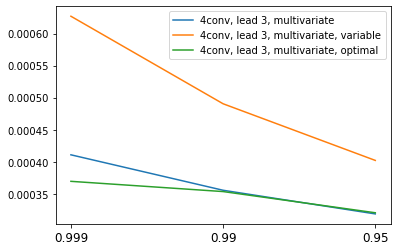

In [86]:
for i in range(len(paths)):
    plt.plot(np.min(train_loss_final_all,axis=-1)[i],label=shortnames[i])
    plt.xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
    plt.legend()
    

In [3]:
## Specify base parameters for experiments to compare:

# exp1: fixed mask
# exp2: variable mask, augmentation factor 1
# exp3a: variable mask, augmentation factor 2
# exp3b: variable mask, augmentation factor 3
# exp4: optimal mask

# Common parameters for all experiments:
model_config = 'unet_4conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.

# Specific parameters for exp1:
mask_types = ['fixed','fixed','fixed']
missing_types = ['discrete','discrete','discrete']
augmentation_factors = [1,1,1]
runs = ['_seed_1', '_seed_2', '_seed_3']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 1:
train_loss_min_exp1 = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp1 = np.min(val_loss_final_all,axis=-1)

# Get min, mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp1 = np.mean(train_loss_min_exp1,axis=0)
val_loss_min_mean_exp1 = np.mean(val_loss_min_exp1,axis=0)
train_loss_min_std_exp1 = np.std(train_loss_min_exp1,axis=0)
val_loss_min_std_exp1 = np.std(val_loss_min_exp1,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_3


In [7]:
### Find epch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )
        
print('\n')

cp -r unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_3/missing_999/epoch_10 unet_4conv_sst_CESM_fixed_discrete_factor_1_final/missing_999/model
cp -r unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_3/missing_999/missing_mask.npy unet_4conv_sst_CESM_fixed_discrete_factor_1_final/missing_999
cp -r unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_3/missing_99/epoch_10 unet_4conv_sst_CESM_fixed_discrete_factor_1_final/missing_99/model
cp -r unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_3/missing_99/missing_mask.npy unet_4conv_sst_CESM_fixed_discrete_factor_1_final/missing_99
cp -r unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_3/missing_95/epoch_9 unet_4conv_sst_CESM_fixed_discrete_factor_1_final/missing_95/model
cp -r unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_3/missing_95/missing_mask.npy unet_4conv_sst_CESM_fixed_discrete_factor_1_final/missing_95
cp -r unet_4conv_sst_CESM_fixed_discrete_factor_1_seed_2/missing_90/epoch_10 unet_4conv_sst_CESM_fixed_discrete_factor_1_final/

In [8]:
# Specific parameters for exp2:
mask_types = ['variable','variable','variable']
missing_types = ['discrete','discrete','discrete']
augmentation_factors = [1,1,1]
runs = ['_seed_1', '_seed_2', '_seed_3']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
 
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 2:
train_loss_min_exp2 = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp2 = np.min(val_loss_final_all,axis=-1)

## Get min, mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp2 = np.mean(train_loss_min_exp2,axis=0)
val_loss_min_mean_exp2 = np.mean(val_loss_min_exp2,axis=0)
train_loss_min_std_exp2 = np.std(train_loss_min_exp2,axis=0)
val_loss_min_std_exp2 = np.std(val_loss_min_exp2,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_1_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_1_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_1_seed_3


In [9]:
### Find epch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )
        
print('\n')

cp -r unet_4conv_sst_CESM_variable_discrete_factor_1_seed_1/missing_999/epoch_9 unet_4conv_sst_CESM_variable_discrete_factor_1_final/missing_999/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_1_seed_1/missing_999/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_1_final/missing_999
cp -r unet_4conv_sst_CESM_variable_discrete_factor_1_seed_1/missing_99/epoch_10 unet_4conv_sst_CESM_variable_discrete_factor_1_final/missing_99/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_1_seed_1/missing_99/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_1_final/missing_99
cp -r unet_4conv_sst_CESM_variable_discrete_factor_1_seed_2/missing_95/epoch_10 unet_4conv_sst_CESM_variable_discrete_factor_1_final/missing_95/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_1_seed_2/missing_95/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_1_final/missing_95
cp -r unet_4conv_sst_CESM_variable_discrete_factor_1_seed_3/missing_90/epoch_8 unet_4conv_s

In [10]:
# Specific parameters for exp3a:
mask_types = ['variable','variable','variable']
missing_types = ['discrete','discrete','discrete']
augmentation_factors = [2,2,2]
runs = ['_seed_1', '_seed_2', '_seed_3']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
 
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 3:
train_loss_min_exp3a = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp3a = np.min(val_loss_final_all,axis=-1)

# Get min, mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp3a = np.mean(train_loss_min_exp3a,axis=0)
val_loss_min_mean_exp3a = np.mean(val_loss_min_exp3a,axis=0)
train_loss_min_std_exp3a = np.std(train_loss_min_exp3a,axis=0)
val_loss_min_std_exp3a = np.std(val_loss_min_exp3a,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_2_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_2_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_2_seed_3


In [11]:
### Find epoch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )
        
print('\n')

cp -r unet_4conv_sst_CESM_variable_discrete_factor_2_seed_1/missing_999/epoch_10 unet_4conv_sst_CESM_variable_discrete_factor_2_final/missing_999/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_2_seed_1/missing_999/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_2_final/missing_999
cp -r unet_4conv_sst_CESM_variable_discrete_factor_2_seed_2/missing_99/epoch_10 unet_4conv_sst_CESM_variable_discrete_factor_2_final/missing_99/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_2_seed_2/missing_99/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_2_final/missing_99
cp -r unet_4conv_sst_CESM_variable_discrete_factor_2_seed_1/missing_95/epoch_10 unet_4conv_sst_CESM_variable_discrete_factor_2_final/missing_95/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_2_seed_1/missing_95/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_2_final/missing_95
cp -r unet_4conv_sst_CESM_variable_discrete_factor_2_seed_1/missing_90/epoch_10 unet_4conv

In [12]:
# Specific parameters for exp3b:
mask_types = ['variable','variable','variable']
missing_types = ['discrete','discrete','discrete']
augmentation_factors = [3,3,3]
runs = ['_seed_1', '_seed_2', '_seed_3']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
 
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 3:
train_loss_min_exp3b = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp3b = np.min(val_loss_final_all,axis=-1)

# Get min, mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp3b = np.mean(train_loss_min_exp3b,axis=0)
val_loss_min_mean_exp3b = np.mean(val_loss_min_exp3b,axis=0)
train_loss_min_std_exp3b = np.std(train_loss_min_exp3b,axis=0)
val_loss_min_std_exp3b = np.std(val_loss_min_exp3b,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_3_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_3_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_3_seed_3


In [13]:
### Find epch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )
print("\n")

cp -r unet_4conv_sst_CESM_variable_discrete_factor_3_seed_3/missing_999/epoch_10 unet_4conv_sst_CESM_variable_discrete_factor_3_final/missing_999/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_3_seed_3/missing_999/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_3_final/missing_999
cp -r unet_4conv_sst_CESM_variable_discrete_factor_3_seed_3/missing_99/epoch_10 unet_4conv_sst_CESM_variable_discrete_factor_3_final/missing_99/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_3_seed_3/missing_99/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_3_final/missing_99
cp -r unet_4conv_sst_CESM_variable_discrete_factor_3_seed_1/missing_95/epoch_10 unet_4conv_sst_CESM_variable_discrete_factor_3_final/missing_95/model
cp -r unet_4conv_sst_CESM_variable_discrete_factor_3_seed_1/missing_95/missing_mask.npy unet_4conv_sst_CESM_variable_discrete_factor_3_final/missing_95
cp -r unet_4conv_sst_CESM_variable_discrete_factor_3_seed_3/missing_90/epoch_10 unet_4conv

In [17]:
# Specific parameters for exp4:
mask_types = ['optimal']
missing_types = ['discrete']
augmentation_factors = [1]
runs = ['_final']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values_exp4 = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values_exp4),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values_exp4),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values_exp4)):

        # Get current sparsity:
        missing = missing_values_exp4[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 1:
train_loss_min_exp4 = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp4 = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp4 = np.mean(train_loss_min_exp4,axis=0)
val_loss_min_mean_exp4 = np.mean(val_loss_min_exp4,axis=0)
train_loss_min_std_exp4 = np.std(train_loss_min_exp4,axis=0)
val_loss_min_std_exp4 = np.std(val_loss_min_exp4,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_optimal_discrete_factor_1_final


In [18]:
### Find epch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/*.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/*.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )

cp -r unet_4conv_sst_CESM_optimal_discrete_factor_1_seed_1/missing_999/epoch_10 unet_4conv_sst_CESM_optimal_discrete_factor_1_final/missing_999/model
cp -r unet_4conv_sst_CESM_optimal_discrete_factor_1_seed_1/missing_999/*.npy unet_4conv_sst_CESM_optimal_discrete_factor_1_final/missing_999
cp -r unet_4conv_sst_CESM_optimal_discrete_factor_1_seed_1/missing_99/epoch_10 unet_4conv_sst_CESM_optimal_discrete_factor_1_final/missing_99/model
cp -r unet_4conv_sst_CESM_optimal_discrete_factor_1_seed_1/missing_99/*.npy unet_4conv_sst_CESM_optimal_discrete_factor_1_final/missing_99
cp -r unet_4conv_sst_CESM_optimal_discrete_factor_1_seed_1/missing_95/epoch_9 unet_4conv_sst_CESM_optimal_discrete_factor_1_final/missing_95/model
cp -r unet_4conv_sst_CESM_optimal_discrete_factor_1_seed_1/missing_95/*.npy unet_4conv_sst_CESM_optimal_discrete_factor_1_final/missing_95


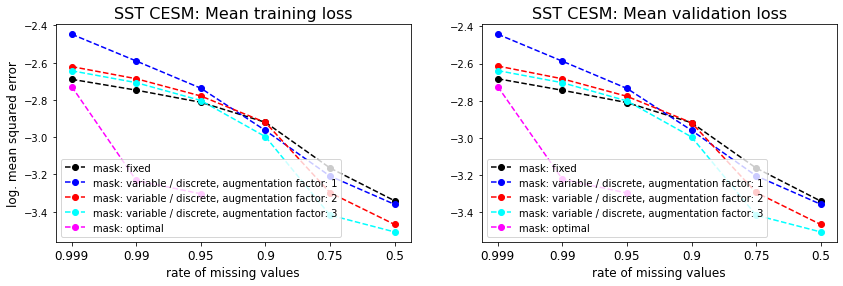

In [19]:
## Optimal masks derived with GMM, grid points with max. rel. loss reduction as representatives.
## Low learning rate: 0.00001

# Set colors for individual experiments:
colors = ['black', 'blue', 'red', 'cyan', 'magenta']
linestyles = ['--', '--', '--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,2,figsize=(14,4))

# exp1:
axes[0].plot(
        np.log10(train_loss_min_mean_exp1), color=colors[0],
        label = 'mask: fixed',
        marker = 'o', linestyle = linestyles[0],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp1), color=colors[0],
        label = 'mask: fixed',
        marker = 'o', linestyle = linestyles[0],
    )

# exp2:
axes[0].plot(
        np.log10(train_loss_min_mean_exp2), color=colors[1],
        label = 'mask: variable / discrete, augmentation factor: 1',
        marker = 'o', linestyle = linestyles[1],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp2), color=colors[1],
        label = 'mask: variable / discrete, augmentation factor: 1',
        marker = 'o', linestyle = linestyles[1],
    )

# exp3a:
axes[0].plot(
        np.log10(train_loss_min_mean_exp3a), color=colors[2],
        label = 'mask: variable / discrete, augmentation factor: 2',
        marker = 'o', linestyle = linestyles[2],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp3a), color=colors[2],
        label = 'mask: variable / discrete, augmentation factor: 2',
        marker = 'o', linestyle = linestyles[2],
    )

# exp3b:
axes[0].plot(
        np.log10(train_loss_min_mean_exp3b), color=colors[3],
        label = 'mask: variable / discrete, augmentation factor: 3',
        marker = 'o', linestyle = linestyles[3],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp3b), color=colors[3],
        label = 'mask: variable / discrete, augmentation factor: 3',
        marker = 'o', linestyle = linestyles[3],
    )

# exp4:
axes[0].plot(
        np.log10(train_loss_min_mean_exp4), color=colors[4],
        label = 'mask: optimal',
        marker = 'o', linestyle = linestyles[4],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp4), color=colors[4],
        label = 'mask: optimal',
        marker = 'o', linestyle = linestyles[4],
    )

# #plt.ylim(0.6, 0.8)
axes[0].set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
axes[1].set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
axes[0].set_title('SST CESM: Mean training loss', fontsize=16)
axes[1].set_title('SST CESM: Mean validation loss', fontsize=16)
axes[0].set_xlabel('rate of missing values', fontsize=12)
axes[1].set_xlabel('rate of missing values', fontsize=12)
axes[0].set_ylabel('log. mean squared error', fontsize=12)
axes[0].legend()
axes[1].legend()
plt.show() 

### Sensitivity check

- Select final models, pretrained on fixed and discrete rel. amount of missing values, **flexible mask type** and **augmentation_factor=2**.
- Feed Validation inputs with *all* sparsities into selected model.
- How does validation loss change?
- Do predictions and targets have identical scales?

In [12]:
# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'CESM' # Choose Earth System Model, either 'FOCI' or 'CESM'.

mask_type = 'variable'
missing_type = 'discrete'
augmentation_factor = 2
run = '_final'

# Get path to stored validation loss from batch:
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

print(path)

# Reload validation loss from sensitivity experiment (batch):
val_loss_all = np.load(path / 'val_loss_all.npy')

# Get validation loss from final model:
val_loss_final = np.diag(val_loss_all)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_CESM_variable_discrete_factor_2_final


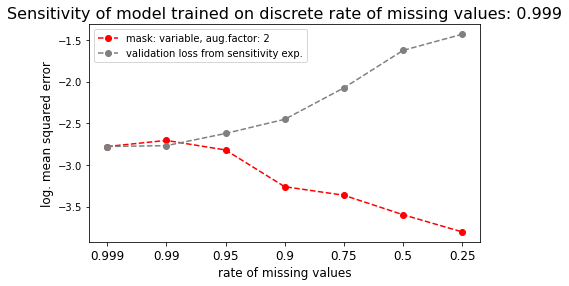

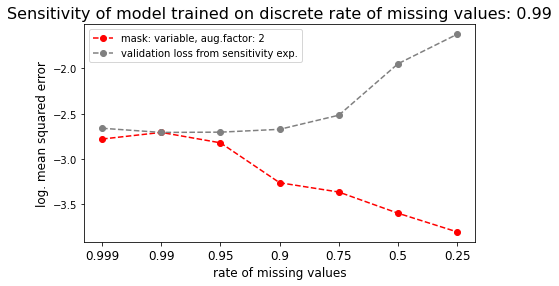

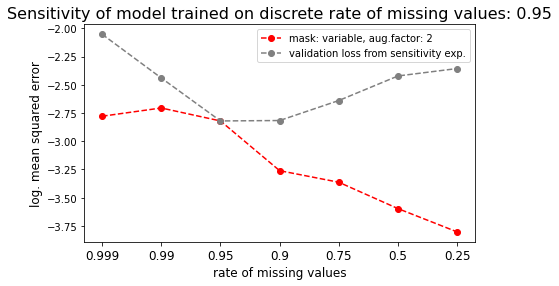

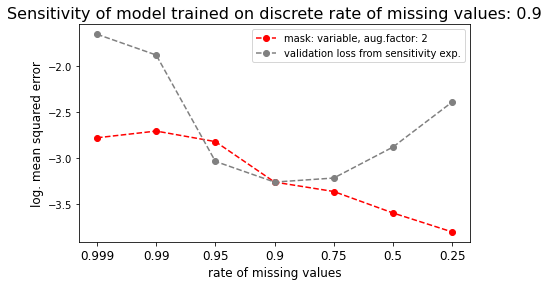

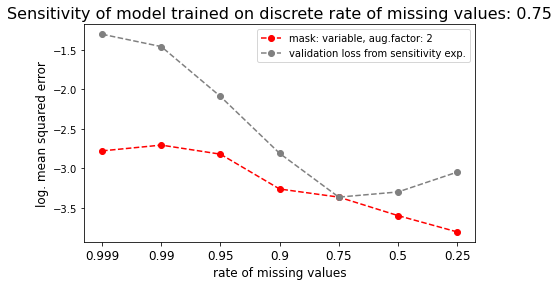

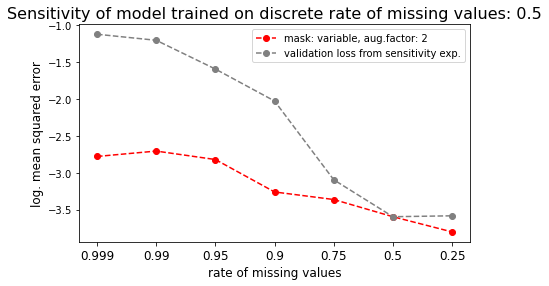

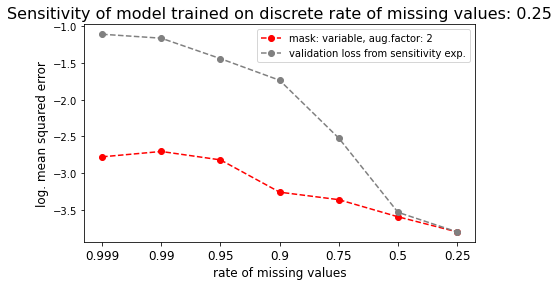

In [15]:
## Plot validation loss over rel. amounts of missing values for sensitivity experiment.

# NOTE: In the above plot, we show the MEAN of all runs as dashed red line.
# However, the sensitivity experiment is performed on the FINAL run, as best of.
# Therefore, show the corresponding final validation loss as dashed red line.
# That needs to match the fixed rel. amount of missing values in any case.

# Loop over fixed rel. amounts of missing values:
for i in range(len(missing_values)):
    
    fig, ax = plt.subplots(1,1,figsize=(7,4))

    # Validation loss, using final models:
    ax.plot(np.log10(val_loss_final), color=colors[2],
                 label = 'mask: ' + mask_type + ', aug.factor: ' + str(augmentation_factor),
                 marker = 'o', linestyle = '--',
        )

    # Final validation loss from sensitivity experiment:
    ax.plot(np.log10(val_loss_all[i]), color='grey',
                 label = 'validation loss from sensitivity exp.',
                 marker = 'o', linestyle = '--',
        )

    ax.set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
    ax.set_title('Sensitivity of model trained on discrete rate of missing values: '+str(missing_values[i]), fontsize=16)
    ax.set_xlabel('rate of missing values', fontsize=12)
    ax.set_ylabel('log. mean squared error', fontsize=12)
    ax.legend()
    plt.show() 

In [111]:
val_target_all.shape

(355, 72, 144)

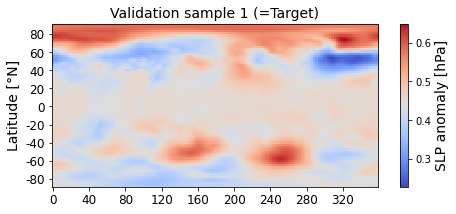

In [118]:
## Compare target to predictions:

# Pick sample number:
k=0

## Plot single validation target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Validation sample '+str(k+1)+' (=Target)', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

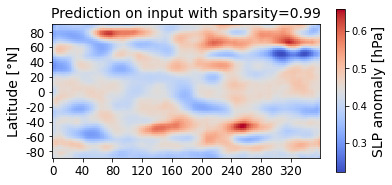

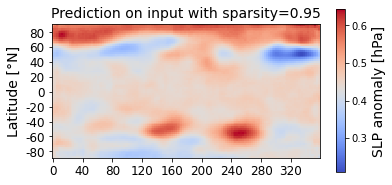

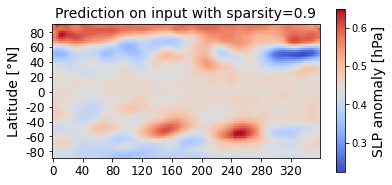

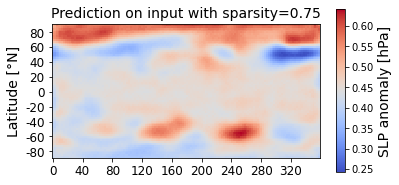

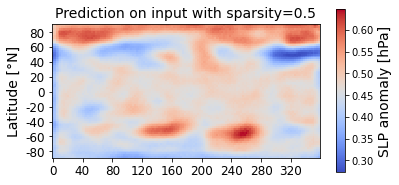

In [122]:
## Plot corresponding model prediction after final epoch:
## Use predictions from model, that is pre-trained on fixed sparsity=0.9, to infer from inputs with various sparsity.

# Loop over sparsities:
for i in range(len(sparsity_all_temp)):
    
    # Get current sparsity:
    sparsity=sparsity_all_temp[i]
    
    fig, ax = plt.subplots(figsize=(6, 3))

    im = plt.imshow(val_pred_all_sparsity_90[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction on input with sparsity='+str(sparsity), fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()